In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import random

dtype: uint8, shape: (584, 565), min: 0, max: 255


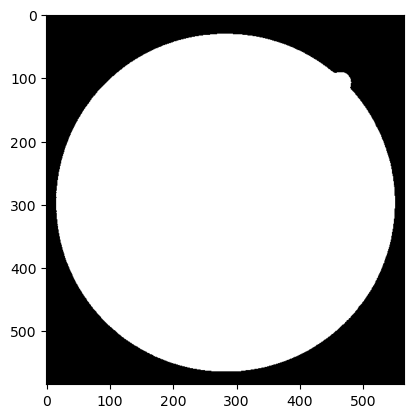

In [2]:
# Create mask
mask_path = r'.\mask_images'
mask = PIL.Image.open(os.path.join(mask_path, '1.tif'))
mask = np.array(mask)
print(f'dtype: {mask.dtype}, shape: {mask.shape}, min: {np.min(mask)}, max: {np.max(mask)}')
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)

In [3]:
# Create label
label_path = r'.\label_images'
label = PIL.Image.open(os.path.join(label_path, '1.tif'))
label = np.array(label)

In [4]:
# Laplacian of Gaussian Filter
def Laplacian_Gaussian_Filter(image, sigma, size=None):
    # If size is not provided, it is calculated based on the sigma value
    if size is None:
        if sigma >= 1:
            size = int(6 * sigma + 1)
        else:
            size = 7

    # Ensure size is odd, so that the center of the kernel is at index (size-1)/2
    if size % 2 == 0:
        size += 1

    # Generate a meshgrid of coordinates, with the range from -size/2 to size/2 in both dimensions
    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))

    # Compute the kernel weights using Gaussian function
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = kernel / np.sum(np.abs(kernel))

    result = cv2.filter2D(image, -1, kernel)

    return result

In [5]:
def local_enhancement(image, block_size=16, clip_limit=2.0): 
    # Split the image into individual channels
    channels = cv2.split(image)
    
    # Create a CLAHE object using the specified clip_limit and block_size
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(block_size, block_size))
    
    # Apply CLAHE to the first (and only) channel of the input image
    enhanced_image = clahe.apply(channels[0])
    
    return enhanced_image

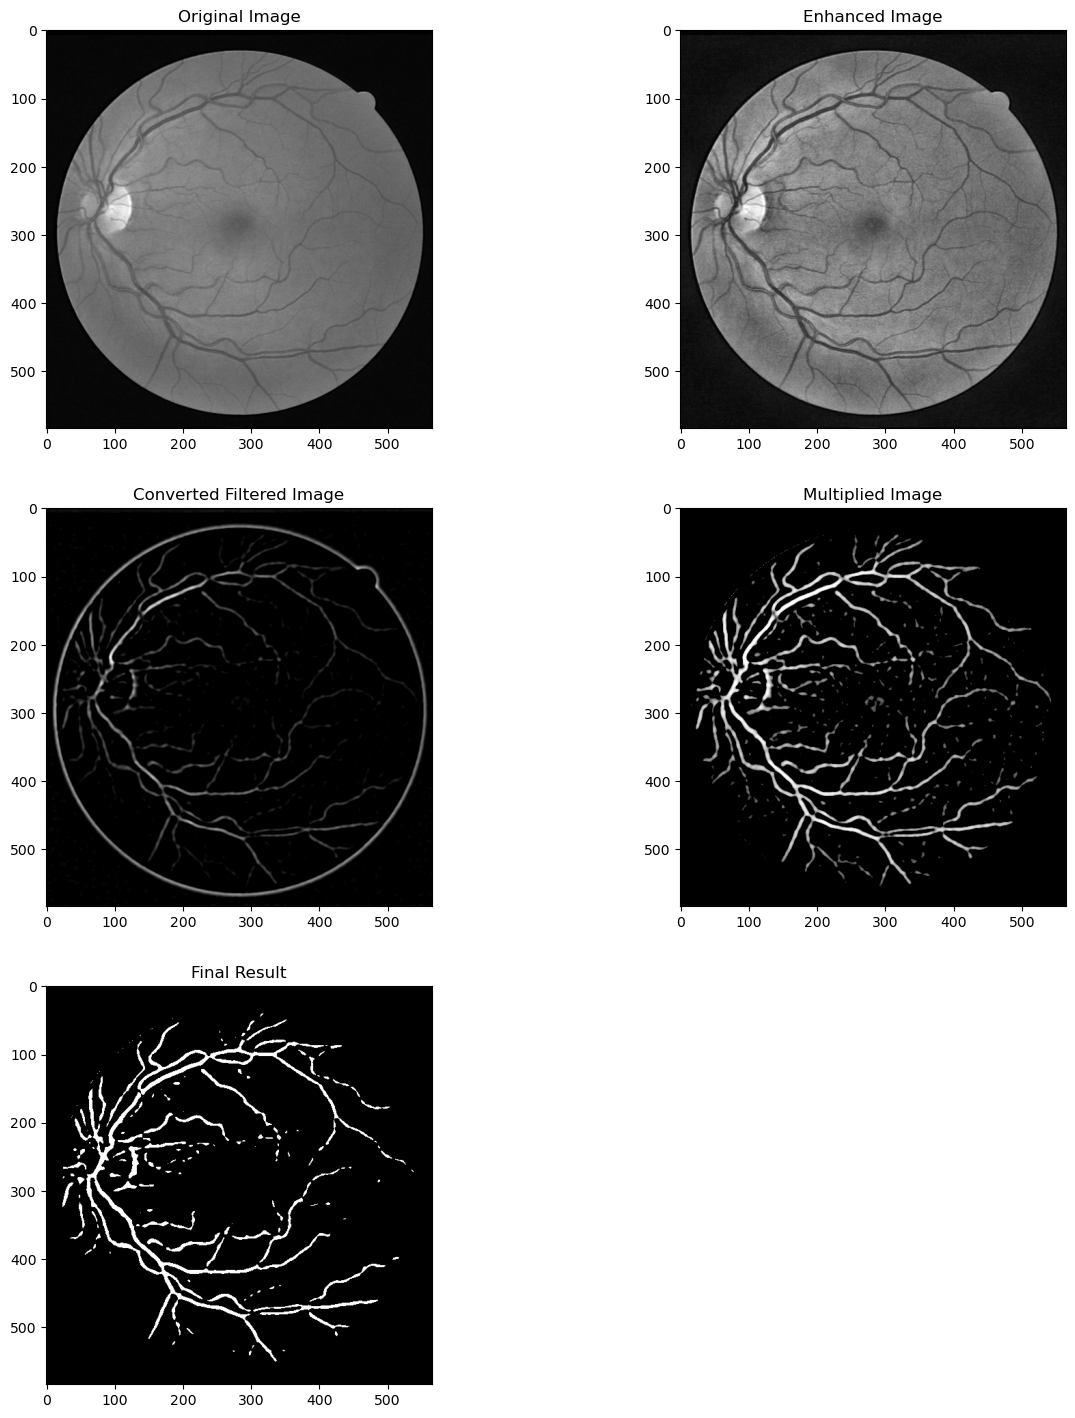

In [21]:
boolean = 0.0000

def main():
    random.seed(0)
    fig = plt.figure(figsize=(15, 30))
    row = 5
    col = 2
    img_path = r'.\retina_images_01_10'
    img = cv2.imread(os.path.join(img_path,'1.tif'), cv2.IMREAD_COLOR)
    imgGreen = img[:,:,1]
    fig.add_subplot(row, col, 1)
    plt.imshow(imgGreen, cmap="gray")
    plt.title("Original Image")

    enhanced_img = local_enhancement(imgGreen)
    fig.add_subplot(row, col, 2)
    plt.imshow(enhanced_img, cmap="gray")
    plt.title("Enhanced Image")
    
    filtered_img = Laplacian_Gaussian_Filter(enhanced_img, 3.0)
    converted_img = cv2.convertScaleAbs(filtered_img)
    fig.add_subplot(row, col, 3)
    plt.imshow(converted_img, cmap="gray")
    plt.title("Converted Filtered Image")
    
    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(converted_img)
    
    multiplied_img = np.multiply(equalized_img, mask / 255)
    _,binary = cv2.threshold(multiplied_img, 125, 255, cv2.THRESH_BINARY)
    boolean = binary > 0
    
    fig.add_subplot(row, col, 4)
    plt.imshow(multiplied_img,cmap='gray')
    plt.title("Multiplied Image")
    
    fig.add_subplot(row, col, 5)
    plt.imshow(boolean*255,cmap='gray')
    plt.title("Final Result")

if __name__ == "__main__":
    main()


In [15]:
TP = sum(sum((label==255) & (boolean==1) & (mask == 255)))
TN = sum(sum((label==0) & (boolean==0) & (mask == 255)))
FP = sum(sum((label==0) & (boolean==1) & (mask == 255)))
FN = sum(sum((label==255) & (boolean==0) & (mask == 255)))
P = TP/(TP+FN)
N = TN/(TN+FP)
T = (TP+TN)/(TP+FN+TN+FP)

In [16]:
P

0.0

In [17]:
N


1.0

In [18]:
T

0.8920299317666249

In [22]:
img_path_1 = r'.\retina_images_01_10'
img_path_2 = r'.\retina_images_11_20'
mask_path = r'.\mask_images'
label_path = r'.\label_images'

P_total, N_total, T_total = 0., 0., 0.

for i in range(1, 21):
    # Load input image
    if i < 11:
        img = cv2.imread(os.path.join(img_path_1,str(i)+'.tif'), cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(os.path.join(img_path_2,str(i)+'.tif'), cv2.IMREAD_COLOR)

    random.seed(0)

    imgGreen = img[:,:,1]

    enhanced_img = local_enhancement(imgGreen)

    filtered_img = Laplacian_Gaussian_Filter(enhanced_img, 3.0)
    converted_img = cv2.convertScaleAbs(filtered_img)

    # Apply histogram equalization
    equalized_img = cv2.equalizeHist(converted_img)
    
    multiplied_img = np.multiply(equalized_img, mask / 255)
    _,binary = cv2.threshold(multiplied_img, 125, 255, cv2.THRESH_BINARY)
    boolean = binary > 0
    
    # Load the label
    label = np.array(PIL.Image.open(os.path.join(label_path,str(i)+'.tif')))
    
    TP = sum(sum((label==255) & (boolean==1) & (mask == 255)))
    TN = sum(sum((label==0) & (boolean==0) & (mask == 255)))
    FP = sum(sum((label==0) & (boolean==1) & (mask == 255)))
    FN = sum(sum((label==255) & (boolean==0) & (mask == 255)))
    P_total += TP/(TP+FN)
    N_total += TN/(TN+FP)
    T_total += (TP+TN)/(TP+FN+TN+FP)

print('P Average: ', P_total/20)
print('N Average: ', N_total/20)
print('T Average: ', T_total/20)

P Average:  0.5602034226104088
N Average:  0.9769744759983029
T Average:  0.9230792371767162
